In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import TargetEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
train_df = pd.read_csv('../data/cleaned_train_with_amenities.csv', dtype={'postal_code': str})
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 31 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   town                       162691 non-null  object 
 1   flat_type                  162691 non-null  object 
 2   block                      162691 non-null  object 
 3   street                     162691 non-null  object 
 4   floor_area_sqm             162691 non-null  float64
 5   flat_model                 162691 non-null  object 
 6   lease_commence_data        162691 non-null  int64  
 7   resale_price               162691 non-null  float64
 8   postal_code                162691 non-null  object 
 9   latitude                   162691 non-null  float64
 10  longitude                  162691 non-null  float64
 11  max_floor                  162691 non-null  int64  
 12  subzone                    162691 non-null  object 
 13  height                     16

In [3]:
train_df.columns

Index(['town', 'flat_type', 'block', 'street', 'floor_area_sqm', 'flat_model',
       'lease_commence_data', 'resale_price', 'postal_code', 'latitude',
       'longitude', 'max_floor', 'subzone', 'height', 'month_from2017',
       'age_at_sale', 'index', 'nearest_mrt', 'mrt_distance', 'mrt_status',
       'nearest_primary_school', 'primary_school_distance',
       'nearest_secondary_school', 'secondary_school_distance', 'nearest_mall',
       'mall_distance', 'nearest_hawker', 'hawker_distance',
       'resale_price_per_sqm', 'flat_type_num', 'flat_model_num'],
      dtype='object')

In [4]:
#drop unused columns
train_df.drop(columns=['block', 'street', 'postal_code', 'subzone',
                       'index', 'nearest_mrt', 'nearest_primary_school', 
                       'nearest_secondary_school', 'nearest_mall', 'nearest_hawker',
                       'resale_price_per_sqm', 'flat_model', 'flat_type'],
                       inplace=True)

In [5]:
encoder = TargetEncoder()
train_df['town'] = encoder.fit_transform(train_df[['town']], train_df['resale_price'])

train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162691 entries, 0 to 162690
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   town                       162691 non-null  float64
 1   floor_area_sqm             162691 non-null  float64
 2   lease_commence_data        162691 non-null  int64  
 3   resale_price               162691 non-null  float64
 4   latitude                   162691 non-null  float64
 5   longitude                  162691 non-null  float64
 6   max_floor                  162691 non-null  int64  
 7   height                     162691 non-null  int64  
 8   month_from2017             162691 non-null  int64  
 9   age_at_sale                162691 non-null  int64  
 10  mrt_distance               162691 non-null  float64
 11  mrt_status                 162691 non-null  int64  
 12  primary_school_distance    162691 non-null  float64
 13  secondary_school_distance  16

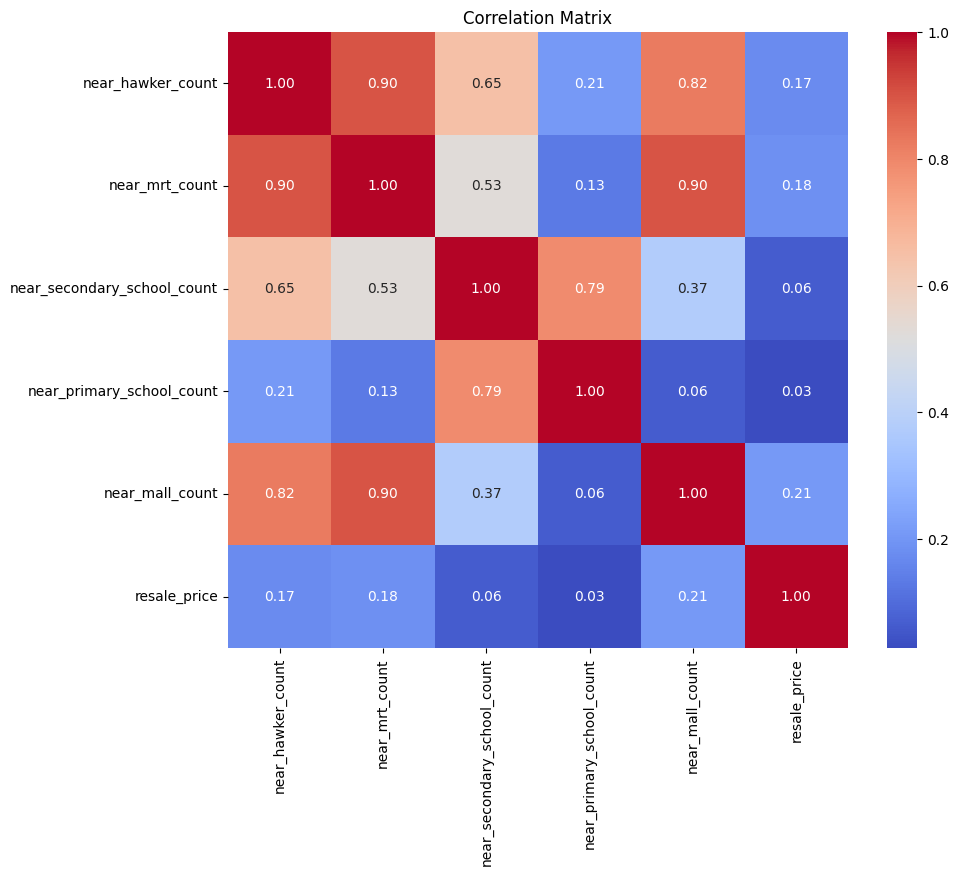

In [8]:
near_amenities = train_df[["near_hawker_count", "near_mrt_count", "near_secondary_school_count", "near_primary_school_count", "near_mall_count", "resale_price"]]
amenities_corr_matrix = near_amenities.corr()

# visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(amenities_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [9]:
train_df.drop(columns=['latitude', 'longitude'], inplace=True)

# Training

In [10]:
# Split the data into features and target variable
X = train_df.drop(columns=['resale_price'])
y = train_df['resale_price']
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
cols = X.columns.tolist()

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[cols])
X_test_scaled = scaler.transform(X_val[cols])

In [12]:
def evaluate_model(model, X_val, y_val):
    y_pred_val = model.predict(X_val)
    
    r2_val = r2_score(y_val, y_pred_val)
    
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    mae_val = mean_absolute_error(y_val, y_pred_val)

    print(f"R2_val: {r2_val} \nRMSE_val: {rmse_val}\nMAE_val: {mae_val}")

In [13]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

evaluate_model(linear_model, X_val, y_val)

R2_val: 0.8340848904172966 
RMSE_val: 74399.37198768687
MAE_val: 57142.53756792646


In [14]:
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_grid = GridSearchCV(
    Ridge(),
    param_grid=ridge_params,
    scoring='neg_root_mean_squared_error',  # RMSE
    cv=5,
    n_jobs=-1
)

ridge_grid.fit(X_train, y_train)
print("Best Ridge alpha:", ridge_grid.best_params_)

evaluate_model(ridge_grid, X_val, y_val)

/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.49109e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.49425e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.48876e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.49685e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-c

Best Ridge alpha: {'alpha': 0.01}
R2_val: 0.8340833310338197 
RMSE_val: 74399.72161491211
MAE_val: 57150.83431048182


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.99261e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


In [15]:
tree_params = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

tree_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=tree_params,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1
)

tree_grid.fit(X_train, y_train)
print("Best Decision Tree parameters:", tree_grid.best_params_)

evaluate_model(tree_grid, X_val, y_val)

Best Decision Tree parameters: {'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
R2_val: 0.9565243858891452 
RMSE_val: 38084.57935651624
MAE_val: 26445.546667389


In [16]:
rf_params = {
    'n_estimators': [100, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=rf_params,
    n_iter=20,  # test 20 random combinations
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

rf_grid.fit(X_train, y_train)
print("Best Random Forest parameters:", rf_grid.best_params_)

evaluate_model(rf_grid, X_val, y_val)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  28.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  28.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  27.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  27.7s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=  27.1s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time= 1.5min
[CV] END max_depth=None, m

/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.8min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 4.8min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time= 2.6min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 2.2min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 2.2min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 2.2min
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10, n_estimators=500; total time= 2.2min
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=300; t

In [17]:
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(max_iter=1000, random_state=42))
])

mlp_params = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (128, 64, 32)],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__activation': ['relu', 'tanh']
}

mlp_grid = RandomizedSearchCV(
    mlp_pipeline,
    param_distributions=mlp_params,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs=-1,
    verbose=2
)

mlp_grid.fit(X_train, y_train)
print("Best MLP parameters:", mlp_grid.best_params_)

evaluate_model(mlp_grid, X_val, y_val)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001; total time= 2.1min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001; total time= 2.1min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001; total time= 2.2min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001; total time= 2.3min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.001; total time= 2.6min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 2.7min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 2.7min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 2.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 2.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.1min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 2.0min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 2.4min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 2.3min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 5.4min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 3.3min
[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 3.0min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.7min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 5.4min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 5.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.4min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.4min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.7min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.7min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.6min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.6min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.9min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01; total time= 2.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01; total time= 2.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01; total time= 2.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01; total time= 2.6min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(50,), mlp__learning_rate_init=0.01; total time= 2.6min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 2.3min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 2.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.9min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=10.9min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 1.9min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 2.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.9min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 7.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=10.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 7.0min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=10.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 7.2min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=10.9min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=10.9min
[CV] END mlp__activation=relu, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 2.4min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.7min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 2.3min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.9min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 4.3min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 1.5min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 1.9min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 2.3min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time= 4.2min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 5.4min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 5.7min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01; total time= 3.4min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01; total time= 3.4min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01; total time= 2.9min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 7.4min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 7.4min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01; total time= 3.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 7.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.01; total time= 3.3min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.1min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.8min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 1.6min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100,), mlp__learning_rate_init=0.001; total time= 3.8min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 1.9min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 2.5min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 2.3min
[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 3.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.6min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 6.7min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=relu, mlp__alpha=0.001, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.001; total time= 7.0min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=11.1min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=11.2min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 7.2min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=11.3min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 7.6min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=11.1min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time=11.1min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time=11.0min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.001, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.001; total time=11.6min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time=10.5min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time=10.2min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(128, 64, 32), mlp__learning_rate_init=0.01; total time=10.0min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 5.0min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 4.8min


/Users/nadia/.pyenv/versions/3.11.11/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=0.01, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate_init=0.01; total time= 4.7min
Best MLP parameters: {'mlp__learning_rate_init': 0.01, 'mlp__hidden_layer_sizes': (128, 64, 32), 'mlp__alpha': 0.01, 'mlp__activation': 'relu'}
R2_val: 0.9742216604619401 
RMSE_val: 29326.063483027807
MAE_val: 21470.613520330273
